In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys 
from glob import glob 
import vaex
from hammer import Model
current = abspath("")
root_dir = abspath(join(current, '..', '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [2]:
from utils import (style, get_params,
                   get_initial_position_normal, get_data, generate_init)

style()

In [3]:
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
z_dir_path

'/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z'

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [18]:
rhob_mean = df_baryon['rho'].to_numpy()
rhob_err = df_baryon['e_rho'].to_numpy()
sigmaz_mean = df_baryon['sigma_z'].to_numpy()
sigmaz_err = df_baryon['e_sigma_z'].to_numpy()

In [14]:
vel_dir_path = join(root_data_dir, "MCMC-no", "mock", "result", "z", "vel", "data")
vel_files = glob(join(vel_dir_path, "*.npy"))
vel_files.sort()
vel_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.6.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.8.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_1.0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_1.5.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_2.0.npy']

In [15]:
index = 0
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
z_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_0.4.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_0.6.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_0.8.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_1.0.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_1.5.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_2.0.hdf5']

In [16]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata = get_data(z_files[index])
kin = np.load(vel_files[index])
zdata, name, kin[:5]

((array([-148.11850576, -135.23593941, -122.35337306, -109.47080671,
          -96.58824037,  -83.70567402,  -70.82310767,  -57.94054132,
          -45.05797497,  -32.17540862,  -19.29284227,   -6.41027592,
            6.47229042,   19.35485677,   32.23742312,   45.11998947,
           58.00255582,   70.88512217,   83.76768852,   96.65025487,
          109.53282121,  122.41538756,  135.29795391,  148.18052026]),
  array([0.28420251, 0.29513338, 0.42357105, 0.58753404, 0.65858467,
         0.75969518, 0.9291236 , 0.96464891, 0.89906372, 0.99197608,
         1.00017423, 1.01930324, 0.88813285, 0.71870443, 0.67771368,
         0.60393034, 0.53287971, 0.37711487, 0.31426239, 0.22408275,
         0.19675559, 0.12570496, 0.11477409, 0.07651606]),
  array([0.02786835, 0.02839922, 0.03402205, 0.04006949, 0.04242317,
         0.04556349, 0.0503888 , 0.05134308, 0.04956699, 0.05206524,
         0.05227994, 0.05277752, 0.04926475, 0.04431721, 0.04303486,
         0.04062475, 0.03816031, 0.0321021

# run_mcmc

In [42]:
from typing import Tuple
from tqdm import tqdm
from time import time
from enum import Enum
from hammer import Model as MCMC_Model
 
class Model(Enum):
    DM = "DM"
    DDDM = "DDDM"
    NO = "NO"
    KIN = "KIN"

func_dict = {
    "DM": MCMC_Model.DM,
    "DDDM": MCMC_Model.DDDM,
    "NO": MCMC_Model.NO,
}

def mcmc_z(model: Model, z_path: str, psi: np.ndarray, **options):
    """
    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    z_path: `str` = path to z file \n
    psi: `np.ndarray` = shape(nsample, ndim) \n
        - rhob: 0..12, \n
        - sigmaz: 12..24, \n
        - r: 24, \n
        - w0: 25, \n
        - log_sigmaw: 26, \n
        - q_sigmaw: 27, \n
        - log_a: 28, \n
        - q_a: 29, \n
    options:
        step0: `int` = 500 \n
        step: `int` = 2000 \n
        burn: `int` = 1000 \n
        it: `int` = 3 \n
        thin: `int` = 20 \n
        verbose: `bool` = True \n
        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { \n
        indexes: `ndarray(shape(nparam))`, \n
        labs: `ndarray(shape(nparam))`, \n
        labels: `ndarray(shape(nparam))`, \n
        chain: `ndarray(shape(nstep,nwalker,nparam))` \n
    }
    """
    step0 = options.get("step0", 100)
    step = options.get("step", 2000)
    burn = options.get("burn", 1000)
    it = options.get("it", 3)
    thin = options.get("thin", 20)
    verbose = options.get("verbose", True)
    m = options.get("m", 10)
    func = func_dict[model.value]
    if verbose: print("running...")
    name = z_path.split("/")[-1].replace(".hdf5", "").replace("z_", "")
    zdata = get_data(z_path)
    
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']    
    indexes = init['indexes']
    labs = init['labs']
    labels = init['labels']

    ndim = len(locs)
    nwalker = m*ndim
    if verbose: print(f"mcmc... {name}")
    p0 = func.generate_p0(nwalker, locs, scales)
    for i in tqdm(range(it), desc="mcmc"):
        t0 = time()
        chain = func.mcmc(step0, zdata, p0, psi, locs, scales, dz=1., parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: first half mcmc done {np.round(t1-t0, 2)} s")
        locs_normal, scales_normal = get_initial_position_normal(model, chain=chain[int(step0/2):])
        p0 = func.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
        t0 = time()
        chain = func.mcmc(step0, zdata, p0, psi, locs, scales, dz=1., parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: second half mcmc done {np.round(t1-t0, 2)} s")
        p0 = chain[-1]
    t0 = time()
    chain = func.mcmc(burn, zdata, p0, psi, locs, scales, dz=1., parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"burn done {np.round(t1-t0, 2)} s")
    p0 = chain[-1]
    t0 = time()
    chain = func.mcmc(step, zdata, p0, psi, locs, scales, dz=1., parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"mcmc done {np.round(t1-t0, 2)} s")
    chain_thin = chain[::thin]
    return {
        "indexes": indexes,
        "labs": labs,
        "labels": labels,
        "chain": chain_thin
        }

In [47]:
nsample = 50
psi = np.empty((nsample, 30))

rhob = np.random.normal(rhob_mean, rhob_err, size=(nsample, 12))
sigmaz = np.random.normal(sigmaz_mean, sigmaz_err, size=(nsample, 12))
r = np.random.normal(3.4E-3, 0.6E-3, size=(nsample))
random_indices = np.random.choice(np.arange(len(psi)), size=nsample, replace=False)
w0 = kin[random_indices, 0]
log_sigmaw = kin[random_indices, 1]
q_sigmaw = kin[random_indices, 2]
log_a = kin[random_indices, 3]
q_a = kin[random_indices, 4]

# combine
psi[:, :12] = rhob
psi[:, 12:24] = sigmaz
psi[:, 24] = r
psi[:, 25] = w0
psi[:, 26] = log_sigmaw
psi[:, 27] = q_sigmaw
psi[:, 28] = log_a
psi[:, 29] = q_a

psi[:5]

array([[ 3.91190882e-03,  2.94527267e-02,  6.73973949e-03,
         4.94850476e-04,  5.65920248e-04,  1.81496439e-03,
         1.99563481e-03,  2.76636984e-03,  6.95915245e-03,
         2.29047059e-02,  6.50506371e-03,  1.85681587e-03,
         3.76708574e+00,  6.31002634e+00,  2.28934545e+01,
         4.23160629e+01,  1.80194879e+01,  7.55217832e+00,
         1.41534614e+01,  1.66637439e+01,  1.68799472e+01,
         2.31138186e+01,  1.77618921e+01,  2.51357035e+01,
         2.73752926e-03, -6.94420829e+00,  1.59342420e+00,
         6.86530265e-01, -3.30411830e-01,  3.18801944e-01],
       [ 1.28105744e-02,  2.24009484e-02,  7.51977664e-03,
         4.81773418e-04,  5.94496853e-04,  1.82138157e-03,
         2.16112149e-03,  3.17250780e-03,  7.20663431e-03,
         2.33275913e-02,  6.75630031e-03,  1.07399297e-03,
         3.91773354e+00,  6.08831543e+00,  2.44432164e+01,
         3.33914351e+01,  1.20801403e+01,  3.66148634e+00,
         4.69903055e+00,  1.81331598e+01,  1.94726893e+

In [49]:
result = mcmc_z(
    model=Model.DM,
    z_path=z_files[index],
    psi=psi,
    step0=50,
    step=500,
    burn=100,
    it=2,
    thin=1,
    m=10
)

result.keys()

running...
mcmc... 0.4


mcmc:   0%|          | 0/2 [00:00<?, ?it/s]

0: first half mcmc done 3.43 s


mcmc:  50%|█████     | 1/2 [00:06<00:06,  6.79s/it]

0: second half mcmc done 3.36 s
1: first half mcmc done 3.31 s


mcmc: 100%|██████████| 2/2 [00:13<00:00,  6.71s/it]

1: second half mcmc done 3.31 s
burn done 6.55 s
mcmc done 31.73 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [50]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(500, 30, 3)

# plot_chain

100%|██████████| 3/3 [00:00<00:00, 83.15it/s]


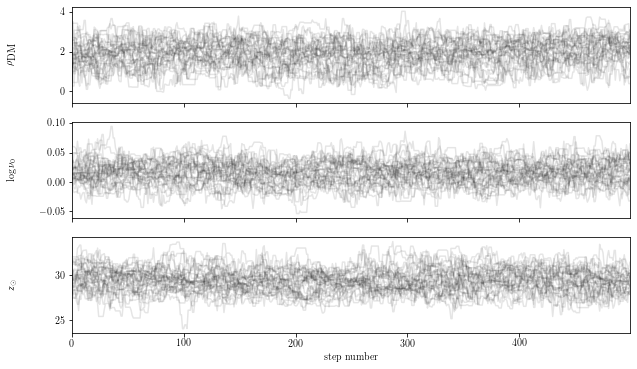

In [53]:
from utils import plot_chain, get_params

params = get_params(chain_thin, indexes, labs)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.1,
    figsize=(10, 6),
)

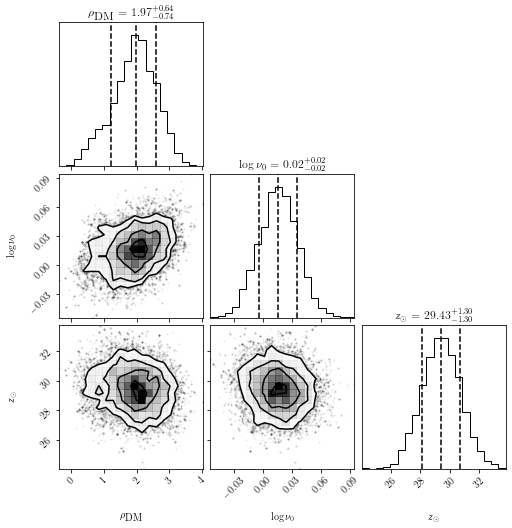

In [52]:
from utils import plot_corner

params = get_params(chain_thin, indexes, labs)

plot_corner(
    params=params,
    labels=labels,
)

# plot_fit

In [60]:
from tqdm import tqdm
from hammer import Model as MCMC_Model
 
class Model(Enum):
    DM = "DM"
    DDDM = "DDDM"
    NO = "NO"
    KIN = "KIN"

func_dict = {
    "DM": MCMC_Model.DM,
    "DDDM": MCMC_Model.DDDM,
    "NO": MCMC_Model.NO,
}


sigma_68 = 0.994458
sigma_90 = 1.644854
sigma_95 = 1.959964

def plot_fit_z(model: Model, flat_chain: np.ndarray, zdata: Tuple[np.ndarray,np.ndarray,np.ndarray], psi: np.ndarray, **options: dict):
    """required: 
            model: `Model` = Model.DM \n
            flat_chain: `ndarray(shape=(nsample, nparam))`\n
            zdata: `Tuple[np.ndarray,np.ndarray,np.ndarray]` = (zmid, znum, zerr) \n
        options:
            res: `int` = 100 \n
            nsample: `int` = 5_000 \n
            figsize: `Tuple[int, int]` = (10, 10) \n
            alpha: `float` = 0.1 \n
            c: `str` = C0 \n
            log: `bool` = False \n
            dpi: `int` = 70 \n
            path: `str` = None \n
            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            """
    res = options.get('res', 100)
    nsample = options.get('nsample', 5_000)
    figsize = options.get('figsize', (10, 6))
    alpha = options.get('alpha', 0.1)
    c = options.get('c', "C0")
    log = options.get('log', False)
    dpi = options.get('dpi', 70)
    path = options.get('path', None)
    fig_kw  = options.get('fig_kw', {})
    func = func_dict.get(model.value, MCMC_Model.DM)
    
    zmid, znum, zerr = zdata
    zs: np.ndarray[np.float64] = np.linspace(zmid.min()*1.1, zmid.max()*1.1, res)
    log_fzs = np.empty((nsample, len(zs)))
    for i in tqdm(range(nsample)):
        ind = np.random.randint(len(flat_chain))
        theta = flat_chain[ind]
        ind = np.random.randint(len(psi))
        ps = psi[ind]
        log_fzs[i] = np.log(func.fz(zs, theta, ps))

    fz_log_mean = log_fzs.mean(axis=0)
    fz_log_std = log_fzs.std(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=figsize, **fig_kw)
    ax.errorbar(zmid, znum, yerr=zerr, color='k',
                alpha=1, capsize=2, fmt=".")
    ax.plot(zs, np.exp(fz_log_mean), c=c, ls="--")
    for sigma in [sigma_95, sigma_90, sigma_68]:
        ax.fill_between(zs, np.exp(fz_log_mean - sigma*fz_log_std),
                        np.exp(fz_log_mean + sigma*fz_log_std), alpha=alpha, color=c)
    ax.set_ylabel(r'$f_0(z)$')
    ax.set_xlabel(r'$z$ [km/s]')
    ax.set_xlim(zs.min(), zs.max())
    if log:
        ax.set_yscale("log")
        ax.set_ylim(np.exp(fz_log_mean - sigma_95*fz_log_std).min(),
                    np.exp(fz_log_mean + sigma_95*fz_log_std).max()*1.5)
    else:
        ax.set_ylim(0)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:02<00:00, 2444.92it/s]


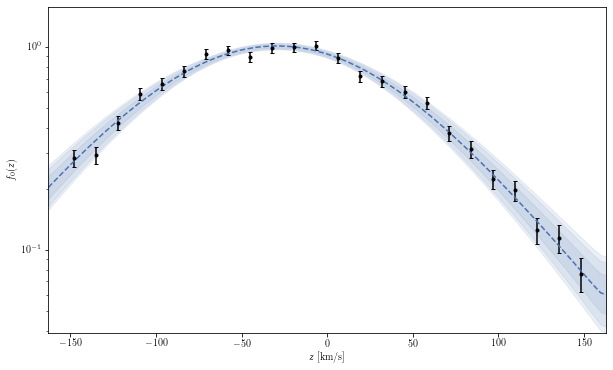

In [61]:
from utils import get_data
zdata = get_data(z_files[index])
flat_chain = chain_thin.reshape(-1, ndim)

plot_fit_z(
    model=Model.DM,
    flat_chain=flat_chain,
    zdata=zdata,
    psi=psi,
    log=True,
    nsample=5_000,
    res=100
)

# calculate max likelihood

In [65]:
from datetime import datetime
from typing import Tuple

def calculate_prob(
        model: Model, 
        flat_chain: np.ndarray, 
        zdata: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        psi: np.ndarray, 
        path: str,
        name: str,
        **options: dict
    ):
    """
    Calculate maximum likelihood, BIC, and AIC, then save the result to a file

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    flat_chain: ndarray(shape=(nsample, ndim)) \n
    zdata: ndarray = (zmid, znum, zerr) \n
    psi: ndarray = (psi) \n
    path: `str` = path to save the result \n
    name: `str` = name of the file \n
    options:
        nsample: `int` = 10_000 \n
        verbose: `bool` = True \n
        batch: `int` = 1000 \n
    """
    nsample = options.get("nsample", 10_000)
    verbose = options.get("verbose", True)
    batch = options.get("batch", 1000)
    func = func_dict[model.value]
    if verbose: print("Opening the data")
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']
    if verbose: print("Opening the chain")
    ndim = flat_chain.shape[1]
    length = len(flat_chain)
    sample = flat_chain[np.random.choice(length, nsample, replace=True)]
    # calculate likelihood
    if verbose: print("Calculating likelihood")
    probs = func.log_prob_par(sample, psi, zdata, locs, scales, dz=1., batch=batch)
    likelihood = probs[:, 1]
    # remove nan from likelihood
    likelihood = likelihood[~np.isnan(likelihood)]
    max_likelihood = np.max(likelihood)
    # calculate BIC
    zmid = zdata[0]
    bic = -2 * max_likelihood + ndim * np.log(3*len(zmid))
    aic = -2 * max_likelihood + 2 * ndim
    print(f"max log-likelihood: {max_likelihood}")
    print(f"BIC: {bic}")
    print(f"AIC: {aic}")
    with open(path, 'a') as f:
        f.write(f"{name},{max_likelihood},{bic},{aic},{datetime.now()}\n")

In [64]:
calculate_prob(
    model=Model.DM, 
    flat_chain=flat_chain,
    zdata=zdata,
    psi=psi,
    name=name,
    path="tes.txt",
)

Opening the data
Opening the chain
Calculating likelihood
max log-likelihood: 50.714555462111626
BIC: -88.59911256717508
AIC: -95.42911092422325


# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# test utils

In [13]:
from os.path import abspath, join
from glob import glob
import vaex
import sys
import numpy as np
current = abspath("")
root_dir = abspath(join(current, '..', '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [2]:
from utils import (style, get_params, mcmc_z, plot_chain, plot_corner, plot_fit_z, calculate_prob, get_data, Model)

style()

In [10]:
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'n')
z_dir_path

'/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n'

In [11]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [6]:
rhob_mean = df_baryon['rho'].to_numpy()
rhob_err = df_baryon['e_rho'].to_numpy()
sigmaz_mean = df_baryon['sigma_z'].to_numpy()
sigmaz_err = df_baryon['e_sigma_z'].to_numpy()

In [7]:
vel_dir_path = join(root_data_dir, "MCMC-no", "mock", "result", "z", "vel", "data")
vel_files = glob(join(vel_dir_path, "*.npy"))
vel_files.sort()
vel_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.6.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.8.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_1.0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_1.5.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_2.0.npy']

In [33]:
index = 5
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
kin = np.load(vel_files[index])

nsample = 100
psi = np.empty((nsample, 30))

rhob = np.random.normal(rhob_mean, rhob_err, size=(nsample, 12))
sigmaz = np.random.normal(sigmaz_mean, sigmaz_err, size=(nsample, 12))
r = np.random.normal(3.4E-3, 0.6E-3, size=(nsample))
random_indices = np.random.choice(np.arange(len(psi)), size=nsample, replace=False)
w0 = kin[random_indices, 0]
log_sigmaw = kin[random_indices, 1]
q_sigmaw = kin[random_indices, 2]
log_a = kin[random_indices, 3]
q_a = kin[random_indices, 4]

# combine
psi[:, :12] = rhob
psi[:, 12:24] = sigmaz
psi[:, 24] = r
psi[:, 25] = w0
psi[:, 26] = log_sigmaw
psi[:, 27] = q_sigmaw
psi[:, 28] = log_a
psi[:, 29] = q_a

In [23]:
print(mcmc_z.__doc__)


    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` 

    z_path: `str` = path to z file 

    psi: `np.ndarray` = shape(nsample, ndim) 

        - rhob: 0..12, 

        - sigmaz: 12..24, 

        - r: 24, 

        - w0: 25, 

        - log_sigmaw: 26, 

        - q_sigmaw: 27, 

        - log_a: 28, 

        - q_a: 29, 

    options:
        step0: `int` = 500 

        step: `int` = 2000 

        burn: `int` = 1000 

        it: `int` = 3 

        thin: `int` = 20 

        verbose: `bool` = True 

        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { 

        indexes: `ndarray(shape(nparam))`, 

        labs: `ndarray(shape(nparam))`, 

        labels: `ndarray(shape(nparam))`, 

        chain: `ndarray(shape(nstep,nwalker,nparam))` 

    }
    


In [34]:
result = mcmc_z(
    model=Model.DM,
    z_path=z_files[index],
    psi=psi,
    step0=100,
    step=1000,
    burn=100,
    it=2,
    thin=3,
    m=10
)

result.keys()

running...
mcmc... 10000


mcmc:   0%|          | 0/2 [00:00<?, ?it/s]

0: first half mcmc done 16.99 s


mcmc:  50%|█████     | 1/2 [00:33<00:33, 33.71s/it]

0: second half mcmc done 16.72 s
1: first half mcmc done 16.89 s


mcmc: 100%|██████████| 2/2 [01:07<00:00, 33.72s/it]

1: second half mcmc done 16.83 s
burn done 16.73 s


mcmc done 165.84 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [35]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(334, 30, 3)

100%|██████████| 3/3 [00:00<00:00, 95.82it/s]


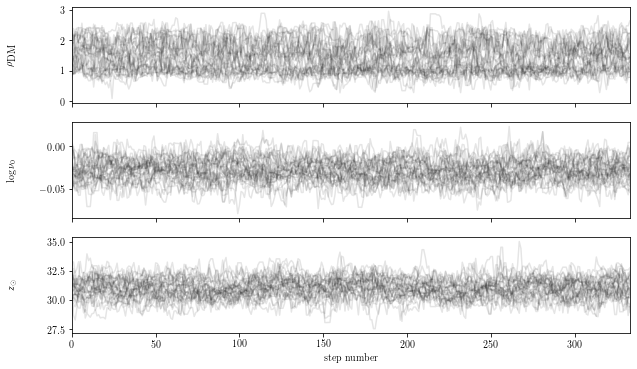

In [36]:
params = get_params(chain_thin, indexes, labs)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.1,
    figsize=(10, 6),
)

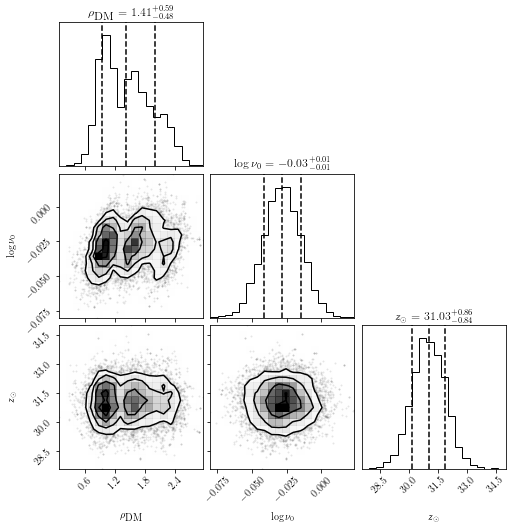

In [37]:
plot_corner(
    params=params,
    labels=labels,
)

100%|██████████| 1000/1000 [00:00<00:00, 1623.44it/s]


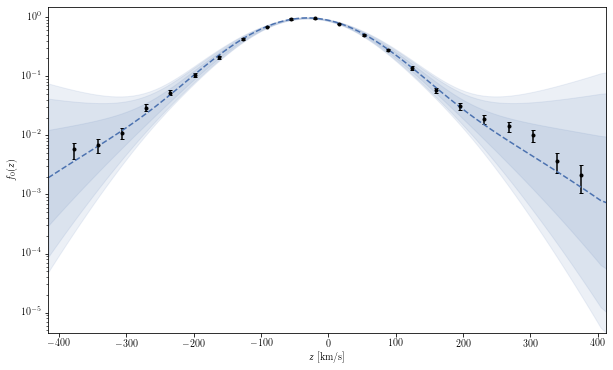

In [39]:
zdata = get_data(z_files[index])
flat_chain = chain_thin.reshape(-1, ndim)

plot_fit_z(
    model=Model.DM,
    flat_chain=flat_chain,
    zdata=zdata,
    psi=psi,
    log=True,
    nsample=1000,
    res=100
)

In [40]:
calculate_prob(
    model=Model.DM, 
    flat_chain=flat_chain,
    zdata=zdata,
    psi=psi,
    name=name,
    path="tes.txt",
    nsample=1000
)

Opening the data
Opening the chain
Calculating likelihood
max log-likelihood: 87.93273236415206
BIC: -163.29650050222483
AIC: -169.86546472830412
